In [85]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb
#!pip install --upgrade folium

In [86]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
## A EXECUTER EN PREMIER POUR SE CONNECTER A ORACLE
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import folium
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import math
from IPython.display import HTML

## Connexion à la base

In [87]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [88]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [89]:
# Saisir ci-dessous l'édition des JO qui vous a été attribuée. Cela correspond au LibelleHote dans la table HOTE de la base de données
# Par exemple EDITION_JO = "2020 Summer Olympics"
EDITION_JO = "2000 Summer Olympics"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = "KRICHA2"

In [90]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

In [91]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.HOTE WHERE LibelleHote LIKE (:libelle)",{"libelle":EDITION_JO})
id_hote = int(data.IDHOTE.iloc[0])
print(f"Identifiant de l’hôte : {id_hote}")

Identifiant de l’hôte : 25


# Présentation générale de l'édition des JO qui vous a été assignée

Les Jeux Olympiques d'été 2000 se sont déroulés à Sydney, en Australie. Ils ont eu lieu du 15 septembre au 1er octobre 2000. 

Pour l'Australie, c'était la deuxième fois qu'elle accueillait les Jeux Olympiques d'été. La première édition avait eu lieu à Melbourne en 1956. Donc, les Jeux de 2000 à Sydney étaient une nouvelle occasion pour l'Australie de se mettre en avant sur la scène sportive mondiale, 44 ans après les Jeux de Melbourne.

### Récupérer les coordonnées des lieux et les mettres sur une carte

In [92]:
# coordonnées de la ville hote
sydney_coords = [-33.8688, 151.2093]
# Créer une carte centrée sur l'australie 
australia_map = folium.Map(location=sydney_coords, zoom_start=5, width=1200, height=250)

# Ajouter un marqueur pour Sydney
folium.Marker(location=sydney_coords, popup='Sydney').add_to(australia_map)
# Définir l'URL pour les épreuves olympiques
url = 'https://www.olympedia.org/venues/editions/25'

# Récupérer le contenu de la page
request = requests.get(url)    
# récupérer le code HTML de la page
codeHTML = BeautifulSoup(request.text, 'html')  
# rechercher la table contenant les épreuve
codeHTML = codeHTML.find('table', class_='table table-striped')   
# ne garder que les lignes contenant un lien vers un lieu
table = codeHTML.find_all('a', href=lambda href: href and '/venues/7' in href)    
# Extraire le href et le nom du lieu
table = [{'href': lien['href'], 'nom': lien.text} for lien in table]

# placer marqueur pour chaque épreuve sur la carte de l'australie
url_lieu = "https://www.olympedia.org"
marker_table = []
for lien in table :
    # lien de la page de l'épreuve
    url_lieu_modif = url_lieu + lien['href']
    # récupere le contenu de la page
    request = requests.get(url_lieu_modif)    
    # récuperer le code HTML de la page
    codeHTML = BeautifulSoup(request.text, 'html')
    # rechercher les lignes contenant les coordonnées de l'épreuve
    coordonnee = codeHTML.find(string=re.compile("(Definitely here)"))
    pattern = r'(-?\d+\.\d+),\s*(-?\d+\.\d+)'
    matches = re.search(pattern, coordonnee)
    # extraire la lattitude et la longitude
    latitude = matches.group(1)
    longitude = matches.group(2)
    coords = [latitude, longitude]
    # ajouter un point sur la carte avec les coordonnées de l'épreuve
    folium.Marker(location=coords).add_to(australia_map)
# afficher la carte des épreuves 
display(HTML(f"<b><font size='+2'>Carte des épreuves des Jeux Olympique d'été 2000</font></b>"))
print(" ")
display(australia_map)

In [93]:
# Calculer avec une requête et afficher les épreuves nouvellement ajoutée à cette édition
nvlleEpreuve  = requete_vers_dataframe(conn, f"""SELECT DISTINCT nomDiscipline FROM {SCHEMA}.DISCIPLINE
NATURAL JOIN {SCHEMA}.EVENEMENT
WHERE idHote = {id_hote} AND nomDiscipline NOT IN (SELECT nomDiscipline FROM {SCHEMA}.DISCIPLINE
                                            NATURAL JOIN {SCHEMA}.EVENEMENT
                                            WHERE idHote = {id_hote}-1)""")

display(HTML(f"<b><font size='+2'>Épreuves nouvellement ajoutées à cette édition</font></b>"))
print(" ")
display(nvlleEpreuve)

,NOMDISCIPLINE
0,Triathlon
1,Trampolining
2,Taekwondo


In [94]:
# recupere les idHote de tout les Jeux Olympique d'été qui n'ont pas été annulés
hoteSummer  = requete_vers_dataframe(conn, f"""SELECT idHote, anneeHote FROM {SCHEMA}.HOTE
WHERE Saison ='Summer' AND DATESCOMPETITION != '—'""")

In [95]:
# Calculer avec une requête et afficher le nombre d'épreuve de chaque genre 
resultats = []
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour afficher les épreuves femmes
    genreEpreuveWomen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    WHERE idHote = {idHote} AND nomEvenement LIKE '%Women%'""")
    # requete pour afficher les épreuves hommes
    genreEpreuveMen  = requete_vers_dataframe(conn, f"""SELECT DISTINCT NomDiscipline, nomEvenement FROM {SCHEMA}.EVENEMENT E
    NATURAL JOIN {SCHEMA}.DISCIPLINE
    WHERE idHote = {idHote} AND nomEvenement LIKE '%Men%'""")
    # calculer le nombre d'épreuve de chaque genre
    nbWomen = genreEpreuveWomen['NOMDISCIPLINE'].count()
    nbMen = genreEpreuveMen['NOMDISCIPLINE'].count()
    # Ajouter les résultats au dictionnaire résultat
    resultats.append({'ANNEEHOTE': anneeHote, 'NBMEN': nbMen, 'NBWOMEN': nbWomen})

# transformer le dictionnarie en dataframe pour l'affichage
df_resultats = pd.DataFrame(resultats)

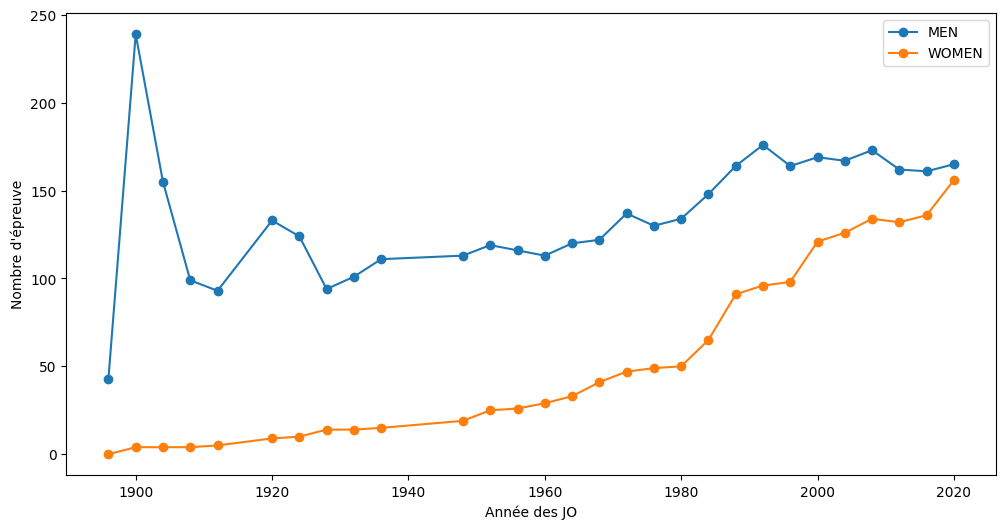

In [96]:
# Définir la taille de la figure
plt.figure(figsize=(12, 6))  
# Tracer MEN
plt.plot(df_resultats.ANNEEHOTE, df_resultats['NBMEN'], marker='o', linestyle='-', label='MEN')
# Tracer WOMEN
plt.plot(df_resultats.ANNEEHOTE, df_resultats['NBWOMEN'], marker='o', linestyle='-', label='WOMEN')

# Ajouter des légendes et titre
display(HTML(f"<b><font size='+2'>Évolution du nombre d'épreuve par genre</font></b>"))
print(" ")
plt.xlabel('Année des JO')
plt.ylabel("Nombre d'épreuve")
display(plt.legend())

Interpréter et/ou expliquer ce qui est présenté : On remarque qu'il y a de plus en plus d'épreuve féminine au Jeux Olympique. Il y a également chez les femmes et les hommes de plus en plus d'épreuve chaque années.

# Comparaison de cette édition avec les éditions qui l'ont précédée

### classement des nations (tableau de classement pour les trois couleurs de médailles et pour le total) + répartition des médailles par couleur et par pays.

In [97]:
# requete pour recuperer le classement NOC médailles
classementNocEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
SUM(CASE WHEN PE.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PE.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PE.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PE.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E 
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
WHERE IDHOTE = '{id_hote}'
GROUP BY EQ.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, eq.noc""")
# requete pour recuperer le classement NOC individuel
classementNocIndividuel = requete_vers_dataframe(conn,f"""SELECT PI.NOC,
SUM(CASE WHEN PI.Medaille = 'Gold' THEN 1 ELSE 0 END) AS Gold,
SUM(CASE WHEN PI.Medaille = 'Silver' THEN 1 ELSE 0 END) AS Silver,
SUM(CASE WHEN PI.Medaille = 'Bronze' THEN 1 ELSE 0 END) AS Bronze,
COUNT(PI.Medaille) AS Total 
FROM {SCHEMA}.EVENEMENT E
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
WHERE IDHOTE = '{id_hote}'
GROUP BY PI.NOC
ORDER BY Total DESC, Gold DESC, Silver DESC, Bronze DESC, noc""")

In [98]:
display(HTML(f"<b><font size='+2'>Classement des nations par médailles durant les {EDITION_JO}</font></b>"))
print(" ")

# création d'un classement global avec les médailles collectives et individuelle
clasementNocGlobal = pd.merge(classementNocEquipe, classementNocIndividuel, on='NOC')
# fusion des colones pour aditionner les médaillles
clasementNocGlobal['GOLD'] = clasementNocGlobal['GOLD_x'] + clasementNocGlobal['GOLD_y']
clasementNocGlobal['SILVER'] = clasementNocGlobal['SILVER_x'] + clasementNocGlobal['SILVER_y']
clasementNocGlobal['BRONZE'] = clasementNocGlobal['BRONZE_x'] + clasementNocGlobal['BRONZE_y']
clasementNocGlobal['TOTAL'] = clasementNocGlobal['TOTAL_x'] + clasementNocGlobal['TOTAL_y']
# trier le dataframe par le total de médailles
clasementNocGlobal = clasementNocGlobal[['NOC', 'GOLD', 'SILVER', 'BRONZE', 'TOTAL']].sort_values(by=['TOTAL'], ascending=False)
# afficher le dataframe
display(clasementNocGlobal)

,NOC,GOLD,SILVER,BRONZE,TOTAL
0,USA,37,24,32,93
3,RUS,32,28,29,89
4,CHN,28,16,14,58
1,AUS,16,25,17,58
2,GER,13,17,26,56
...,...,...,...,...,...
67,LUX,0,0,0,0
68,MAD,0,0,0,0
70,MAS,0,0,0,0
72,MRI,0,0,0,0


Interpréter et/ou expliquer ce qui est présenté : l'Australie à réaliser son meilleur résultat, surement car les Jeux Olympique 2000 se déroulait à Sydney. 

# Répartition des médailles

In [136]:
def calculeMoyenne(serie): 
    nb = 0
    n = 0
    for index, row in serie.iterrows():
        n+= row['NBATHLETE']
        nb += row['NBATHLETE']*row['NBMEDAILLE']
    if n==0:
        return 0
    return nb/n

def calculeEcartType(serie): 
    nb = 0
    n = 0
    for index, row in serie.iterrows():
        n+= row['NBATHLETE']
        nb += row['NBATHLETE']*(row['NBMEDAILLE'])**2
    if n==0:
        return 0
    variance =  nb/n
    return math.sqrt(variance)

def minSerie(serie):
    minVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] < minVal or first:
            minVal = row['NBMEDAILLE']
            first = False
    return minVal

def maxSerie(serie):
    maxVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] > maxVal or first:
            maxVal = row['NBMEDAILLE']
            first = False
    return maxVal

def quartilsSerie(serie):
    quartils = list()
    frequence_relative_cumulee = 0
    taille_echantillon = serie['NBATHLETE'].sum()
    if taille_echantillon == 0:
        return[0,0,0]
    for index,row in serie.iterrows(): 
        frequence_relative_cumulee += (row['NBATHLETE']/taille_echantillon)
        if (frequence_relative_cumulee>=0.25):
            quartils.append(row['NBMEDAILLE'])
        if (frequence_relative_cumulee>=0.50):
            quartils.append(row['NBMEDAILLE'])
        if (frequence_relative_cumulee>=0.75):
            quartils.append(row['NBMEDAILLE'])
    return quartils

def nbMedaille(serie):
    somme = 0
    for index,row in serie.iterrows(): 
        somme += row["NBMEDAILLE"]*row["NBATHLETE"]
    return somme

In [151]:
#Tableau Statistique répartions par genre : nb de médailles par athelte en moyenne + ecart type etc...

saison = requete_vers_dataframe(conn, "SELECT distinct anneehote FROM hote WHERE saison = 'Summer' and anneeHote < 2000 ORDER BY anneehote")

moyennes = list()
ecarts = list()
min = list()
max = list()

serie_hommes  = requete_vers_dataframe(conn, f"""SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                FROM {SCHEMA}.medailles_athletes_2000 ma
                                                INNER JOIN {SCHEMA}.athlete a ON a.idathlete = ma.idathlete
                                                WHERE genre = 'Male'
                                                GROUP BY total
                                                ORDER BY total
                                           """)

serie_femmes  = requete_vers_dataframe(conn, f"""SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                    FROM {SCHEMA}.medailles_athletes_2000 ma
                                                    INNER JOIN {SCHEMA}.athlete a ON a.idathlete = ma.idathlete
                                                    WHERE genre = 'Female'
                                                    GROUP BY total
                                                    ORDER BY total
                                           """)


moyennes.append(calculeMoyenne(serie_hommes))
moyennes.append(calculeMoyenne(serie_femmes))

ecarts.append(calculeEcartType(serie_hommes))
ecarts.append(calculeEcartType(serie_femmes))

quartil_hommes = quartilsSerie(serie_hommes)
quartil_femmes = quartilsSerie(serie_femmes)

min.append(minSerie(serie_hommes))
min.append(minSerie(serie_femmes))

max.append(maxSerie(serie_hommes))
max.append(maxSerie(serie_femmes))

nb_medaille_homme = nbMedaille(serie_hommes)
nb_medaille_femme = nbMedaille(serie_femmes)

statistiques_2000 = {
    'Annee': ['2000', '2000'],
    'Genre': ['Homme', 'Femme'],
    'Moyenne': moyennes,
    'Ecart Type': ecarts,
    '1er quartil': [quartil_hommes[0], quartil_femmes[0]],
    'Médiane': [quartil_hommes[1], quartil_femmes[1]],
    '3e quartil': [quartil_hommes[2], quartil_femmes[2]],
    'Min': min,
    'Max': max,
    'TotalMedaille' : [nb_medaille_homme, nb_medaille_femme]
}

statistiques_2000 = pd.DataFrame(statistiques_2000)

display(HTML(f"<b><font size='+2'>Différence Homme/Femme pendant {EDITION_JO}</font></b>"))
display(statistiques_2000)

statistiques_avant_2000 = pd.DataFrame({
    'Annee':[],
    'Genre': [],
    'Moyenne': [],
    'Ecart Type': [],
    '1er quartil': [],
    'Médiane': [],
    '3e quartil': [],
    'Min': [],
    'Max': [],
    'TotalMedaille': []
})

display(statistiques_avant_2000)

for i, row in saison.iterrows():
    serie_homme_saison = requete_vers_dataframe(conn, f"""
                                                        SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                        FROM (SELECT idathlete,
                                                        COUNT(medaille) AS total
                                                        FROM 
                                                        (SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM athlete a
                                                        LEFT JOIN participation_individuelle pi ON a.idAthlete = pi.idAthlete
                                                        INNER JOIN evenement e ON e.idevenement = pi.idevent
                                                        INNER JOIN hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Male' AND saison = 'Summer' AND  anneeHote = {row['ANNEEHOTE']}
                                                        UNION ALL
                                                        SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM athlete a
                                                        LEFT JOIN composition_equipe ce ON a.idAthlete = ce.idAthlete
                                                        INNER JOIN participation_equipe pe ON pe.idequipe = ce.idequipe
                                                        INNER JOIN evenement e ON e.idevenement = pe.idevenement
                                                        INNER JOIN hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Male' AND saison = 'Summer' AND anneeHote = {row['ANNEEHOTE']})
                                                        GROUP BY idathlete, nomathlete, prenomathlete)
                                                        GROUP BY total
                                                        ORDER BY total
                                                        """)
    
    ecart = quartilsSerie(serie_homme_saison)

    rang = {
        'Annee': row['ANNEEHOTE'],
        'Genre': 'Homme',
        'Moyenne': calculeMoyenne(serie_homme_saison),
        'Ecart Type': calculeEcartType(serie_homme_saison),
        '1er quartil': ecart[0],
        'Médiane': ecart[1],
        '3e quartil': ecart[0],
        'Min': minSerie(serie_homme_saison),
        'Max': maxSerie(serie_homme_saison),
        'TotalMedaille': nbMedaille(serie_homme_saison)
    }

    rang_df = pd.DataFrame([rang])

    # Utiliser pd.concat pour ajouter la nouvelle ligne
    statistiques_avant_2000 = pd.concat([statistiques_avant_2000, rang_df], ignore_index=True)
    
    serie_femme_saison = requete_vers_dataframe(conn, f"""
                                                        SELECT total as NBMEDAILLE, count(*) as nbAthlete
                                                        FROM (SELECT idathlete,
                                                        COUNT(medaille) AS total
                                                        FROM 
                                                        (SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM athlete a
                                                        LEFT JOIN participation_individuelle pi ON a.idAthlete = pi.idAthlete
                                                        INNER JOIN evenement e ON e.idevenement = pi.idevent
                                                        INNER JOIN hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Female' AND saison = 'Summer' AND  anneeHote = {row['ANNEEHOTE']}
                                                        UNION ALL
                                                        SELECT 
                                                        a.idathlete, a.nomathlete, a.prenomathlete, medaille
                                                        FROM athlete a
                                                        LEFT JOIN composition_equipe ce ON a.idAthlete = ce.idAthlete
                                                        INNER JOIN participation_equipe pe ON pe.idequipe = ce.idequipe
                                                        INNER JOIN evenement e ON e.idevenement = pe.idevenement
                                                        INNER JOIN hote h ON e.idhote = h.idhote
                                                        WHERE genre = 'Female' AND saison = 'Summer' AND anneeHote = {row['ANNEEHOTE']})
                                                        GROUP BY idathlete, nomathlete, prenomathlete)
                                                        GROUP BY total
                                                        ORDER BY total
                                                        """)
    
    ecart = quartilsSerie(serie_femme_saison)

    rang = {
        'Annee': int(row['ANNEEHOTE']),
        'Genre': 'Femme',
        'Moyenne': calculeMoyenne(serie_femme_saison),
        'Ecart Type': calculeEcartType(serie_femme_saison),
        '1er quartil': ecart[0],
        'Médiane': ecart[1],
        '3e quartil': ecart[0],
        'Min': minSerie(serie_femme_saison),
        'Max': maxSerie(serie_femme_saison),
        'TotalMedaille': nbMedaille(serie_femme_saison)
    }

    rang_df = pd.DataFrame([rang])

    # Utiliser pd.concat pour ajouter la nouvelle ligne
    statistiques_avant_2000 = pd.concat([statistiques_avant_2000, rang_df], ignore_index=True)

moyennes_avant_2000 = list()
ecarts_avant_2000 = list()
min_avant_2000 = list()
max_avant_2000 = list()

display(statistiques_avant_2000)

,Annee,Genre,Moyenne,Ecart Type,1er quartil,Médiane,3e quartil,Min,Max,TotalMedaille
0,2000,Homme,0.170006,0.450113,0,0,0,0,6,1137
1,2000,Femme,0.218388,0.522884,0,0,0,0,5,905


,Annee,Genre,Moyenne,Ecart Type,1er quartil,Médiane,3e quartil,Min,Max,TotalMedaille


,Annee,Genre,Moyenne,Ecart Type,1er quartil,Médiane,3e quartil,Min,Max,TotalMedaille
0,1896.0,Homme,0.609959,1.135983,0.0,0.0,0.0,0.0,6.0,147.0
1,1896.0,Femme,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1900.0,Homme,0.285782,0.671051,0.0,0.0,0.0,0.0,5.0,601.0
3,1900.0,Femme,0.342105,0.777987,0.0,0.0,0.0,0.0,2.0,13.0
4,1904.0,Homme,0.358616,0.814540,0.0,0.0,0.0,0.0,6.0,487.0
5,1904.0,Femme,1.666667,2.000000,1.0,1.0,1.0,0.0,3.0,10.0
6,1908.0,Homme,0.381033,0.673686,0.0,0.0,0.0,0.0,3.0,900.0
7,1908.0,Femme,0.296296,0.577350,0.0,0.0,0.0,0.0,2.0,16.0
8,1912.0,Homme,0.340796,0.664085,0.0,0.0,0.0,0.0,5.0,959.0
9,1912.0,Femme,0.483871,0.803219,0.0,0.0,0.0,0.0,2.0,30.0


## Répartion du nombre de médaille gagnées par genre

[19616.0, 5035.0]


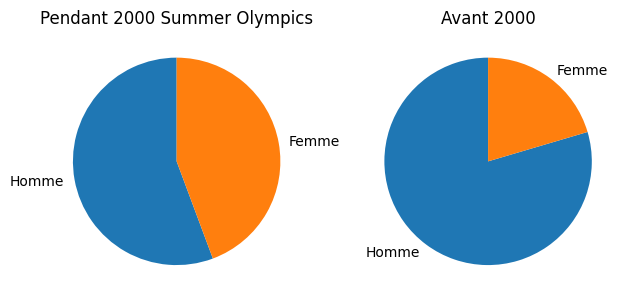

In [152]:
# Grille pour les afficher l'un à coté de l'autre (1 ligne, 2 colonnes)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(statistiques_2000['TotalMedaille'],labels=['Homme', 'Femme'], startangle=90)
ax1.set_title('Pendant 2000 Summer Olympics')

repartition = [0,0]
for i, row in statistiques_avant_2000.iterrows():
    if row['Genre'] == 'Homme':
        repartition[0] += row['TotalMedaille']
    else:
        repartition[1] += row['TotalMedaille']

ax2.pie(repartition, labels=['Homme', 'Femme'],startangle=90)
ax2.set_title('Avant 2000')

# Ajustement de la disposition pour éviter les chevauchements
plt.tight_layout()

plt.show()

## Moyenne et écart type du nombre de médaille gagné par genre

,Genre,Moyenne,Ecart Type,1er quartil,Médiane,3e quartil,Min,Max,TotalMedaille
0,Femme,0.309472,0.619215,0.038462,0.038462,0.038462,0.0,7.0,5035.0
1,Homme,0.221681,0.505906,0.000000,0.000000,0.000000,0.0,8.0,19616.0


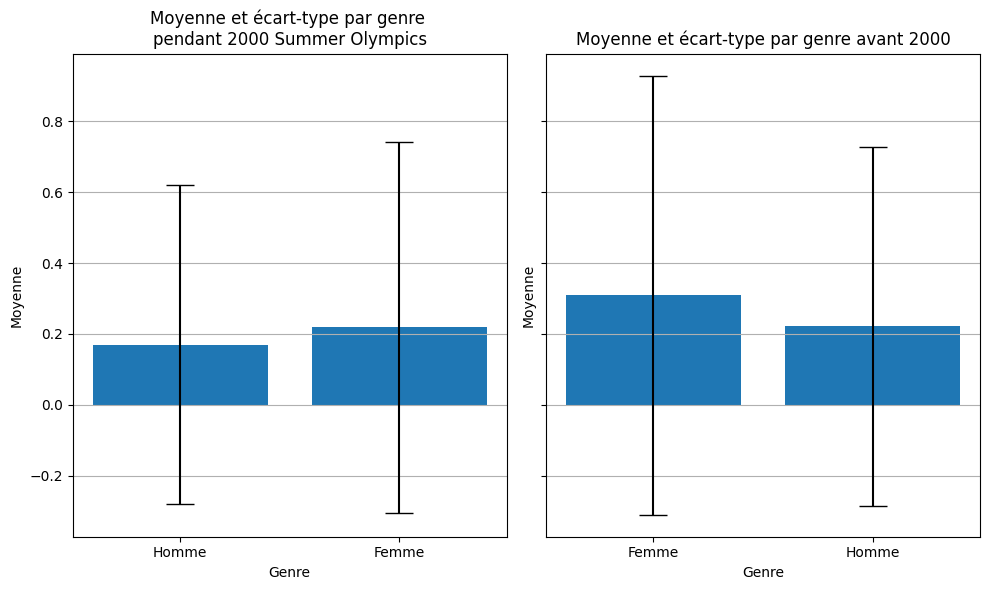

In [160]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

stats_avant_2000_groupe = statistiques_avant_2000.groupby('Genre')
stats_avant_2000_groupe = stats_avant_2000_groupe.agg({
    'Moyenne': 'mean',
    'Ecart Type': 'mean',
    '1er quartil': 'mean',
    'Médiane': 'mean',
    '3e quartil': 'mean',
    'Min': 'min',
    'Max': 'max',
    'TotalMedaille': 'sum'
}).reset_index()

display(stats_avant_2000_groupe)

x_pos = range(len(statistiques_2000['Genre']))
axs[0].bar(x_pos, statistiques_2000['Moyenne'], yerr=statistiques_2000['Ecart Type'], align='center', capsize=10)
axs[0].set_xlabel('Genre')
axs[0].set_ylabel('Moyenne')
axs[0].set_title('Moyenne et écart-type par genre \npendant 2000 Summer Olympics')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(statistiques_2000['Genre'])
axs[0].yaxis.grid(True)

x_pos = range(len(stats_avant_2000_groupe['Genre']))
axs[1].bar(x_pos, stats_avant_2000_groupe['Moyenne'], yerr=stats_avant_2000_groupe['Ecart Type'], align='center', capsize=10)
axs[1].set_xlabel('Genre')
axs[1].set_ylabel('Moyenne')
axs[1].set_title('Moyenne et écart-type par genre avant 2000')
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(stats_avant_2000_groupe['Genre'])
axs[1].yaxis.grid(True)

# Affichage du graphique
plt.tight_layout()
plt.show()

On remarque que le premier quartil, la médianne et le 3e quartils sont égals à 0. Ils sont égals à 0 car obtenir une médailles aux Jeux Olympiques est très rare, ainsi, le nombre de personne sans médaille est largement plus grand (>75%) que le nombre de personne à en avoir obtenus.
Étant donné que ces indicateurs sont à 0, cela n'est pas pertinents de les afficher sur un graphique.

## Répartion des médailles gagnées par pays

In [103]:
def calculerMoyenneMedailleNoc(serie):
    somme = 0
    nbNoc = 0
    for i, row in serie.iterrows():
        somme += row['NBMEDAILLE']
        nbNoc += 1
    if nbNoc == 0:
        return 0
    return somme/nbNoc

def calculerEcartTypeMedailleNoc(serie):
    somme = 0
    nbNoc = 0
    for i, row in serie.iterrows():
        somme += row['NBMEDAILLE']^2
        nbNoc += 1
    if nbNoc == 0:
        return 0
    return math.sqrt(somme/nbNoc)

def minSerieNoc(serie):
    minVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] < minVal or first:
            minVal = row['NBMEDAILLE']
            first = False
    return minVal

def maxSerieNoc(serie):
    maxVal = int()
    first = True
    for index, row in serie.iterrows():
        if row['NBMEDAILLE'] > maxVal or first:
            maxVal = row['NBMEDAILLE']
            first = False
    return maxVal

def quartilsSerieNoc(serie):
    quartils = list()
    nb_element = serie["NBMEDAILLE"].count()
    if(nb_element%4 == 0):
        quartils.append(serie["NBMEDAILLE"][(nb_element//4)-1])
        quartils.append((serie["NBMEDAILLE"][(nb_element//2)-1]+serie["NBMEDAILLE"][(nb_element/2)-1])/2)
        quartils.append(serie["NBMEDAILLE"][(3*nb_element//4)-1])
    else:
        quartils.append(serie["NBMEDAILLE"][(nb_element//4)])
        quartils.append(serie["NBMEDAILLE"][(nb_element//2)])
        quartils.append(serie["NBMEDAILLE"][(3*nb_element//4)])
    return quartils

In [118]:
#IDEM : Faire moyenne "Un américain gagne en moyenne x medailles
# lors des 2000 et x medailles lors des avant"

serie_noc_2000 = requete_vers_dataframe(conn, f"""
                                        SELECT * FROM {SCHEMA}.medailles_noc_athletes
                                        """)

serie_noc_avant_2000 = requete_vers_dataframe(conn, f"""
                                        SELECT * FROM {SCHEMA}.medailles_noc_athletes_avant_2000
                                        """)

quartil_2000 = quartilsSerieNoc(serie_noc_2000)

quartil_avant_2000 = quartilsSerieNoc(serie_noc_avant_2000)

statistiques_global_nocs = {
    'Édition' : ['2000 Summer Olympics', 'Moyenne des éditions avant 2000'],
    'Moyenne': [calculerMoyenneMedailleNoc(serie_noc_2000), calculerMoyenneMedailleNoc(serie_noc_avant_2000)],
    'Ecart-Type': [calculerEcartTypeMedailleNoc(serie_noc_2000), calculerMoyenneMedailleNoc(serie_noc_avant_2000)],
    '1er quartil': [quartil_2000[0],quartil_avant_2000[0]],
    'Médianne': [quartil_2000[1],quartil_avant_2000[1]],
    '3e quartil': [quartil_2000[2],quartil_avant_2000[2]],
    'Min': [minSerieNoc(serie_noc_2000),minSerieNoc(serie_noc_avant_2000)],
    'Max': [maxSerieNoc(serie_noc_2000),maxSerieNoc(serie_noc_avant_2000)],
}

statistiques_global_nocs = pd.DataFrame(statistiques_global_nocs)

display(statistiques_global_nocs)

,Édition,Moyenne,Ecart-Type,1er quartil,Médianne,3e quartil,Min,Max
0,2000 Summer Olympics,10.210000,3.392639,0.0,0.000000,4.000000,0.0,253.000000
1,Moyenne des éditions avant 2000,9.530274,9.530274,0.0,0.142857,3.555556,0.0,233.888889


On remarque une légère hausse du nombre de médaille moyen lors des jeux de 2000. C'est probablement du à un haut du tableau qui remonte cette moyenne car la médianne est quand meme plus faible que lors des éditions précédentes. On remarque que le nombre maximale de médaille est lui aussi plus élévé en 2000 : 253 médaille, pour les éditions précédentes, en moyenne le nombre max de médaille est de 234.

### répartition des médailles par continent (Amérique, Europe, Asie, Afrique, Océanie), comparaison là aussi avec les outils vus en statistiques. [Bonus]

In [105]:
# Créer une nouvelle table continent

Interpréter et/ou expliquer ce qui est présenté : 

### autres idées de répartitions pertinentes [Bonus]

Interpréter et/ou expliquer ce qui est présenté : 

### Évolution des membres du TOP3 par rapport à l'édition précédente

In [106]:
### évolution à long terme pour le top 3 de cette édition (c'est-à-dire que pour les trois meilleurs pays de cette édition, on veut savoir quelle était leur performance sur les jeux de même type (jeux d'été ou jeux d'hiver) lors des éditions qui ont précédé).

# récupere les idHote des 3 pays avec le plus de médailles
idTop3 = [clasementNocGlobal['NOC'].loc[i] for i in range(3)]
# initialisation d'un dataframe 
resultats_top3 = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NOC', 'TOTAL'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # pour chaque pays du TOP3 (USA, GER, AUS)
    for noc in idTop3:
        # requete pour recupérer le nombre de médailles par équipe de {noc} durant {idhote}
        ClassementEquipe = requete_vers_dataframe(conn,f"""SELECT EQ.NOC,
        COUNT(PE.Medaille) AS Total 
        FROM {SCHEMA}.EVENEMENT E 
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEvenement = E.idEvenement
        INNER JOIN {SCHEMA}.EQUIPE EQ ON PE.idEquipe = EQ.idEquipe
        WHERE IDHOTE = {idHote}
        GROUP BY EQ.NOC
        HAVING EQ.NOC = '{noc}'""")
        # requete pour recupérer le nombre de médailles en individuelle de {noc} durant {idhote}
        ClassementIndividuelle = requete_vers_dataframe(conn,f"""SELECT idAthlete, COUNT(PI.Medaille) AS Total 
        FROM {SCHEMA}.EVENEMENT E
        INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idEvent = E.idEvenement
        WHERE IDHOTE = {idHote} AND NOC = '{noc}'
        GROUP BY idAthlete""")
        # assigner l'idHote et l'annéeHote à la ligne pour concatener
        ClassementEquipe['IDHOTE'] = idHote
        ClassementEquipe['ANNEEHOTE'] = anneeHote
        # ajouter le total des médailles individuelles au total des médailles en équipe pour avoir le nombre de médaille total
        ClassementEquipe['TOTAL'] += ClassementIndividuelle['TOTAL'].sum()
        # ajouter la ligne dans un dataframe
        resultats_top3 = pd.concat([resultats_top3, ClassementEquipe], ignore_index=True)

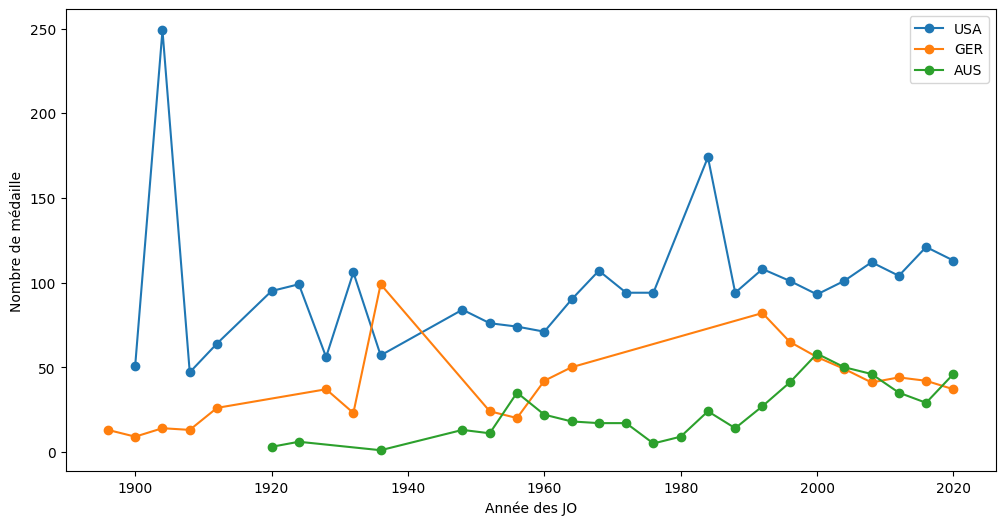

In [107]:
# créer un dataframe pour chaque nation pour afficher les statistique
resultats_top3USA = resultats_top3[resultats_top3['NOC'] == 'USA']
resultats_top3GER = resultats_top3[resultats_top3['NOC'] == 'GER']
resultats_top3AUS = resultats_top3[resultats_top3['NOC'] == 'AUS']

# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer USA
plt.plot(resultats_top3USA.ANNEEHOTE, resultats_top3USA['TOTAL'], marker='o', linestyle='-', label='USA')
# Tracer GER
plt.plot(resultats_top3GER.ANNEEHOTE, resultats_top3GER['TOTAL'], marker='o', linestyle='-', label='GER')
# Tracer AUS
plt.plot(resultats_top3AUS.ANNEEHOTE, resultats_top3AUS['TOTAL'], marker='o', linestyle='-', label='AUS')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année des JO')
plt.ylabel('Nombre de médaille')
display(HTML(f"<b><font size='+2'>Évolution du nombre de médaille par nation </font></b>"))
print(" ")
plt.legend()

Interpréter et/ou expliquer ce qui est présenté : On remarque que l'Allemagne n'a pas gagné de médaille entre 1970 et 1980, car le pays était divisée en deux délégations (RDA et RFA). Depuis, l'Allemagne remporte de moins en moins de médaille, car les autres pays deviennent de plus en plus fort, et le pays doit se restructurer après la réunification, donc investis moins dans le sport.

### Tailles des délégations (et tendances à long terme). [Bonus]

In [108]:
## J'AI PAS FAIT LES TENDANCES A LONG TERME
# initialisation d'un dataframe
taille_deleg = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NOC'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # pour chaque pays du TOP3 (USA, GER, AUS)
    for noc in idTop3:
        # requete pour recupérer le nombre d'athlete
        nbAthleteNoc = requete_vers_dataframe(conn, f"""SELECT COUNT(DISTINCT idAthlete) FROM (
        SELECT PI.idAthlete FROM {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
        INNER JOIN {SCHEMA}.HOTE H ON H.idHote = E.idHote
        WHERE H.idHote ={idHote} AND PI.NOC = '{noc}'
        UNION ALL
        SELECT CE.idAthlete FROM COMPOSITION_EQUIPE CE
        INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe
        INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
        INNER JOIN {SCHEMA}.EQUIPE EQ ON EQ.idEquipe = PE.idEquipe
        INNER JOIN {SCHEMA}.HOTE H ON H.idHote = E.idHote
        WHERE H.idHote = {idHote} AND EQ.NOC = '{noc}')""")
         # assigner l'idHote, l'annéeHote et noc à la ligne pour concatener 
        nbAthleteNoc['IDHOTE'] = idHote
        nbAthleteNoc['ANNEEHOTE'] = anneeHote
        nbAthleteNoc['NOC'] = noc
        # concatener la ligne 
        taille_deleg = pd.concat([taille_deleg, nbAthleteNoc], ignore_index=True)
# renommer la colonnes count pour plus de clarete
taille_deleg = taille_deleg.rename(columns={'COUNT(DISTINCTIDATHLETE)': 'NBATHLETE'})

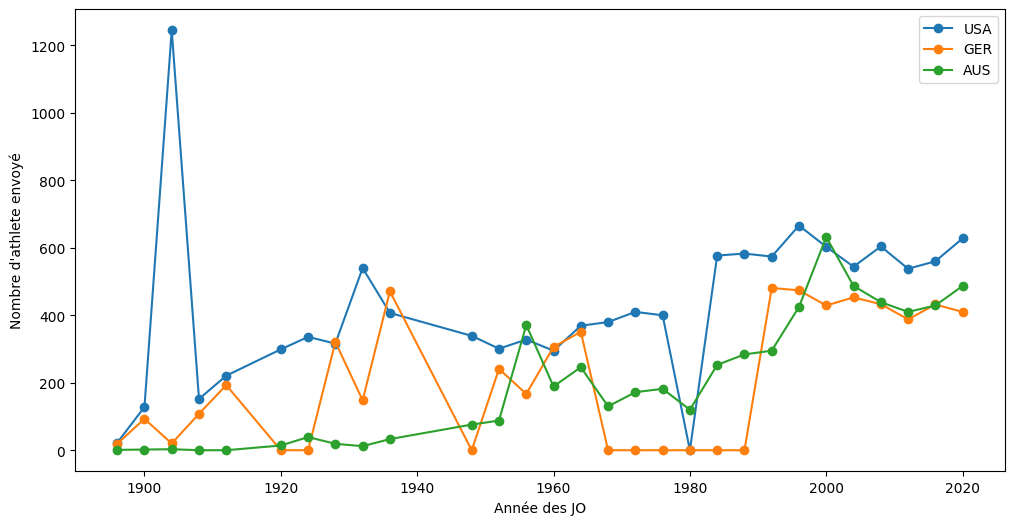

In [109]:
# créer un dataframe pour chaque nation pour afficher les statistique
taille_delegUSA = taille_deleg[taille_deleg['NOC'] == 'USA']
taille_delegGER = taille_deleg[taille_deleg['NOC'] == 'GER']
taille_delegAUS = taille_deleg[taille_deleg['NOC'] == 'AUS']
# Tracer les données avec matplotlib
plt.figure(figsize=(12, 6))  # Définir la taille de la figure

# Tracer USA
plt.plot(taille_delegUSA.ANNEEHOTE, taille_delegUSA['NBATHLETE'], marker='o', linestyle='-', label='USA')
# Tracer GER
plt.plot(taille_delegGER.ANNEEHOTE, taille_delegGER['NBATHLETE'], marker='o', linestyle='-', label='GER')
# Tracer AUS
plt.plot(taille_delegAUS.ANNEEHOTE, taille_delegAUS['NBATHLETE'], marker='o', linestyle='-', label='AUS')

# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Année des JO')
plt.ylabel("Nombre d'athlete envoyé")
display(HTML(f"<b><font size='+2'>Évolution du nombre d'athlete envoyé par chaque délégation </font></b>"))
print(" ")
plt.legend()

Interpréter et/ou expliquer ce qui est présenté : On vois que lors de l'édition de 1980, les États-Unis ont décider de boycotter l'édition se déroulant en URSS, en envoyant aucun athlete. On vois également qu'a partir de 1970 et jusqu'en 1990, l'allemgne n'a envoyé aucun athlete. Cause de la division du pays en deux délégation (RDA et RFA). Depuis, la réunification, la taille de la délégation se stabilise autour de 500 athlete, tout comme l'Australie.

### Moyennes d'âge des athlètes (et tendances à long terme).

In [110]:
# PAS FAIT TENDANCE A LONG TERME
# initialisation de dataFrame
moyenneAgeJOMen = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
moyenneAgeJOWomen = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
moyenneAgeJO = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'AGEMOYEN'])
# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour récuperer l'age moyen des hommes au moment de leurs participations au JO
    ageAthleteMen = requete_vers_dataframe(conn,f"""SELECT DISTINCT idAthlete,  
    (ANNEEHOTE - EXTRACT(YEAR FROM DATENAISSANCE)) AS AGECOMPET FROM {SCHEMA}.ATHLETE 
    NATURAL JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
    NATURAL JOIN {SCHEMA}.HOTE
    WHERE DateDeces IS NULL AND DATENAISSANCE IS NOT NULL AND idHote = {idHote} AND genre = 'Male'""")
    # requete pour récuperer l'age moyen des femmes au moment de leurs participations au JO
    ageAthleteWomen = requete_vers_dataframe(conn,f"""SELECT DISTINCT idAthlete,  
    (ANNEEHOTE - EXTRACT(YEAR FROM DATENAISSANCE)) AS AGECOMPET FROM {SCHEMA}.ATHLETE 
    NATURAL JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI
    INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
    NATURAL JOIN {SCHEMA}.HOTE
    WHERE DateDeces IS NULL AND DATENAISSANCE IS NOT NULL AND idHote = {idHote} AND genre = 'Female'""")
    # Supprimer les doublons
    ageAthleteWomen = ageAthleteWomen.drop_duplicates(subset='IDATHLETE')
    ageAthleteMen = ageAthleteMen.drop_duplicates(subset='IDATHLETE')
    # calculer l'age moyen
    ageMoyenMen = ageAthleteMen['AGECOMPET'].mean()
    ageMoyenWomen = ageAthleteWomen['AGECOMPET'].mean()
    # concatener (ajouter ligne à un dataFrame)
    moyenneAgeJOMen = pd.concat([moyenneAgeJOMen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenMen]})], ignore_index=True)
    moyenneAgeJOWomen = pd.concat([moyenneAgeJOWomen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenWomen]})], ignore_index=True)

/var/folders/_8/9y5h4x1j2bb46lcy0wbgplmh0000gn/T/ipykernel_7286/110595975.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moyenneAgeJOMen = pd.concat([moyenneAgeJOMen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEHOTE': [anneeHote], 'AGEMOYEN': [ageMoyenMen]})], ignore_index=True)
/var/folders/_8/9y5h4x1j2bb46lcy0wbgplmh0000gn/T/ipykernel_7286/110595975.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  moyenneAgeJOWomen = pd.concat([moyenneAgeJOWomen, pd.DataFrame({'IDHOTE': [idHote], 'ANNEEH

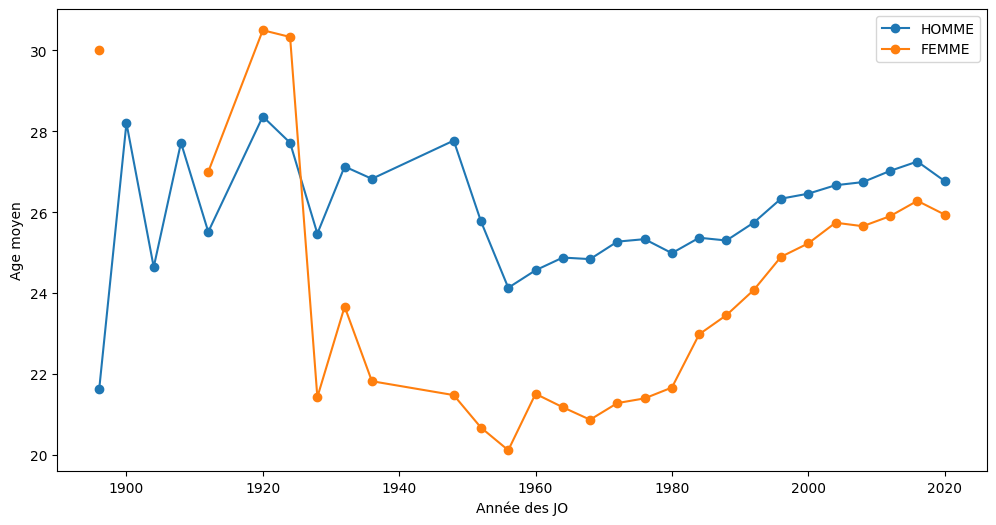

In [111]:
# Définir la taille de la figure
plt.figure(figsize=(12, 6))  

# Tracer HOMME
plt.plot(moyenneAgeJOMen.ANNEEHOTE, moyenneAgeJOMen['AGEMOYEN'], marker='o', linestyle='-', label='HOMME')
# Tracer FEMME
plt.plot(moyenneAgeJOWomen.ANNEEHOTE, moyenneAgeJOWomen['AGEMOYEN'], marker='o', linestyle='-', label='FEMME')

# Ajouter des légendes et titre
plt.xlabel('Année des JO')
plt.ylabel('Age moyen')
display(HTML(f"<b><font size='+2'>Évolution de l'age moyen des athlete par genre </font></b>"))
print(" ")
plt.legend()

Interpréter et/ou expliquer ce qui est présenté : On vois que lors des JO de 1896, une femme de trente ans à participer, alors que les femmes y était interdite. Stamata Revithi est une femme qui as couru le marathon Homme. On vois également que depuis 196., l'age moyen ne cesse d'augmenter, problament due à la profesionnalisation du sport. La ou auparavant les athlete envoyé était amateur.

### Tailles des athlètes (et tendances à long terme). [Bonus]

In [112]:
# requete renvoyant la taille des athletes fessant des sport collectif
tailleMoyenSportCollectifGenre = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete, nomSport, taille, Genre FROM {SCHEMA}.ATHLETE A
INNER JOIN {SCHEMA}.COMPOSITION_EQUIPE CE ON CE.idAthlete = A.idAthlete
INNER JOIN {SCHEMA}.PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe 
INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PE.idEvenement
INNER JOIN {SCHEMA}.DISCIPLINE D ON D.CodeDiscipline = E.CodeDiscipline
INNER JOIN {SCHEMA}.SPORT S ON S.CodeSport = D.CodeSport""")
# requete renvoyant la taille des athletes fessant des sport individuel 
tailleMoyenSportIndividuelGenre = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete, nomSport, taille, Genre FROM {SCHEMA}.ATHLETE A
INNER JOIN {SCHEMA}.PARTICIPATION_INDIVIDUELLE PI ON PI.idAthlete = A.idAthlete
INNER JOIN {SCHEMA}.EVENEMENT E ON E.idEvenement = PI.idEvent
INNER JOIN {SCHEMA}.DISCIPLINE D ON D.CodeDiscipline = E.CodeDiscipline
INNER JOIN {SCHEMA}.SPORT S ON S.codeSport = D.CodeSport""")

In [113]:
# calculer la taille moyenne par sport et par genre
taille_moyenneGenreIndividuelle = tailleMoyenSportIndividuelGenre.groupby(['GENRE', 'NOMSPORT'])['TAILLE'].mean().reset_index()
taille_moyenneGenreEquipe = tailleMoyenSportCollectifGenre.groupby(['GENRE', 'NOMSPORT'])['TAILLE'].mean().reset_index()
# trier par taille décroissante
taille_moyenneGenreEquipe = taille_moyenneGenreEquipe.sort_values(by=['TAILLE'], ascending=False)
taille_moyenneGenreIndividuelle = taille_moyenneGenreIndividuelle.sort_values(by=['TAILLE'], ascending=False)

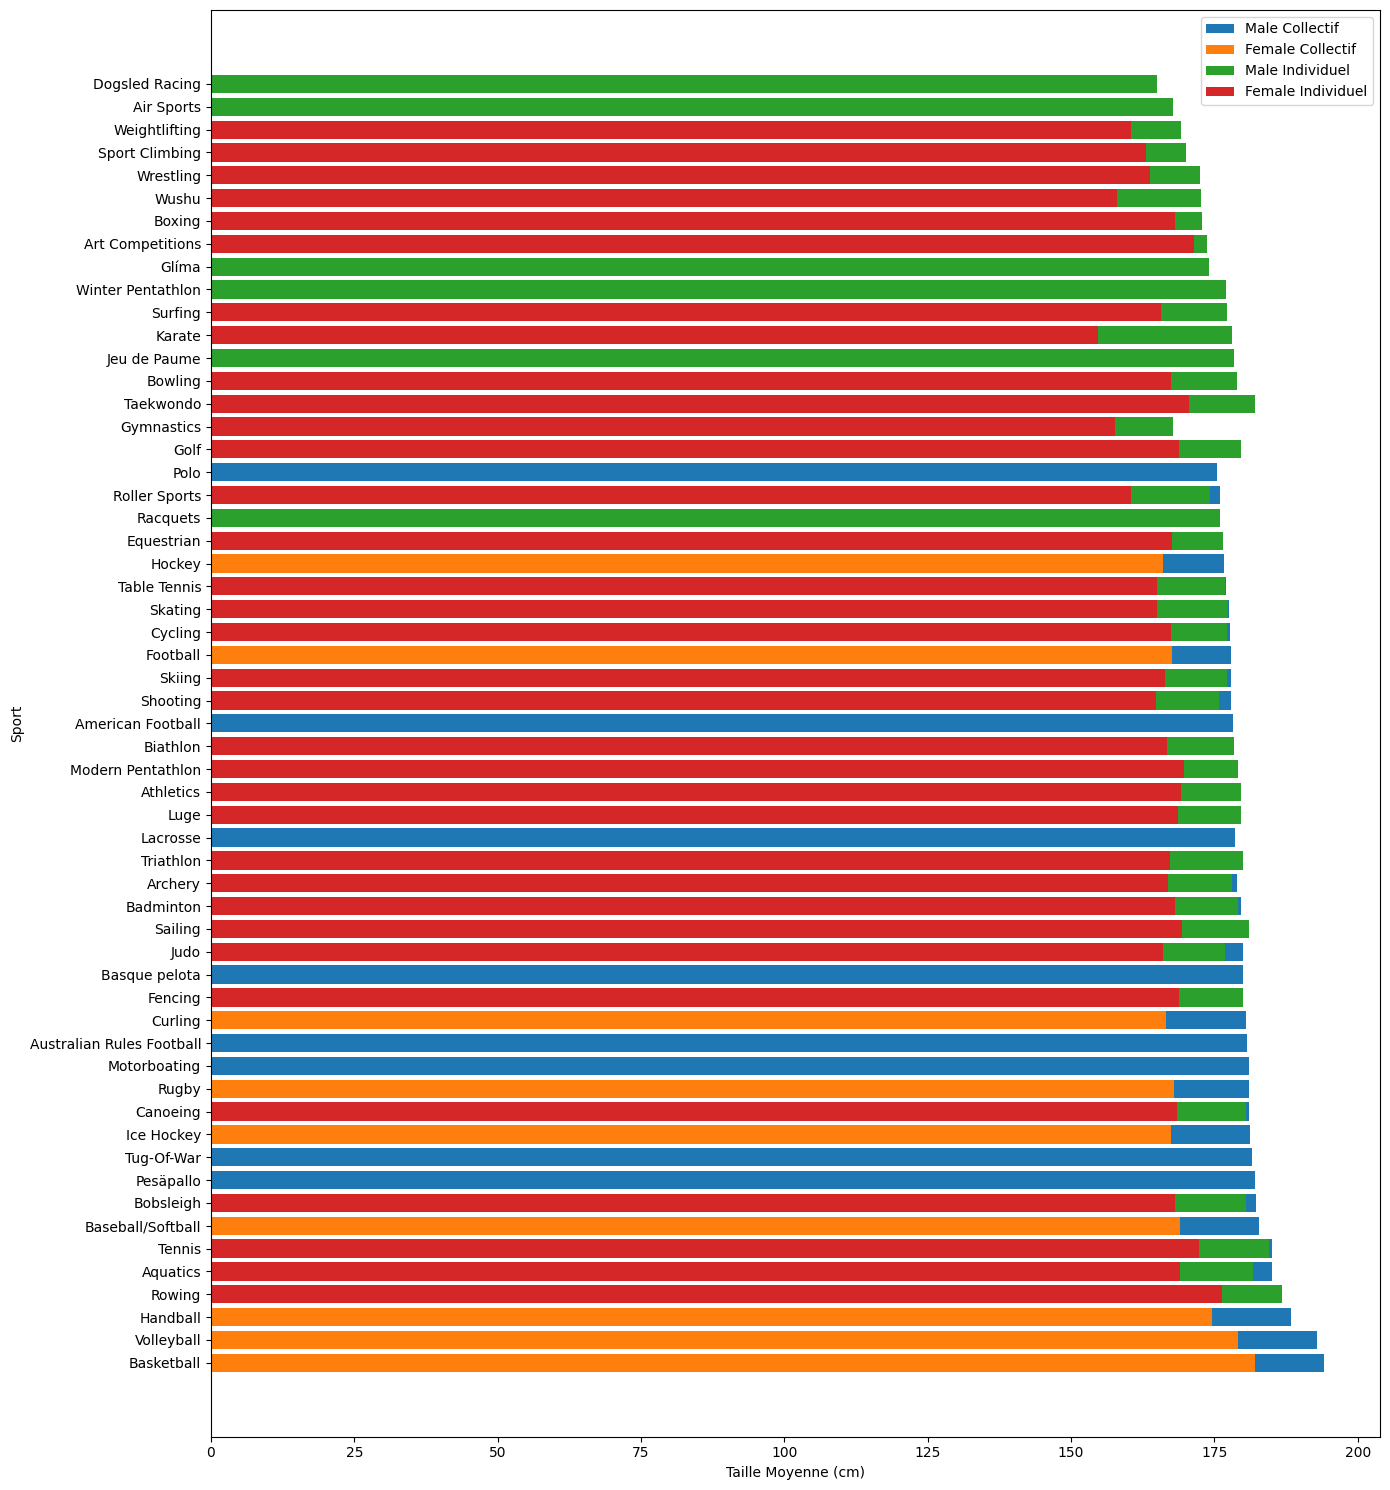

In [114]:
# Création de la figure
plt.figure(figsize=(14, 15))

# Tracer les barres pour les sports collectifs
for genre in taille_moyenneGenreEquipe['GENRE'].unique():
    df = taille_moyenneGenreEquipe[taille_moyenneGenreEquipe['GENRE'] == genre]
    # enlever les sport ou taille est null
    df = df[~np.isnan(df['TAILLE'])]
    # tracer la bare
    plt.barh(df['NOMSPORT'], df['TAILLE'], label=f'{genre} Collectif')

# Tracer les barres pour les sports individuels
for genre in taille_moyenneGenreIndividuelle['GENRE'].unique():
    df = taille_moyenneGenreIndividuelle[taille_moyenneGenreIndividuelle['GENRE'] == genre]
    # enlever les sport ou taille est null
    df = df[~np.isnan(df['TAILLE'])]
    # tracer la bare
    plt.barh(df['NOMSPORT'], df['TAILLE'], label=f'{genre} Individuel')
    
# Ajouter des légendes, titre, étiquettes d'axe
plt.xlabel('Taille Moyenne (cm)')
plt.ylabel('Sport')
display(HTML(f"<b><font size='+2'>Taille Moyenne des Athlètes par Sport et par Genre </font></b>"))
print(" ")
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

Interpréter et/ou expliquer ce qui est présenté : On vois que certain sport comme le polo, le Tug-Of-War ou la pelote basque, était des sport reservé au hommes, donc aucune femmes n'y a jamais participé. On vois également que les sport où les athletes sont les plus grands sont le basketball et le volleyBall, ce qui est cohérent car la taille représente un atout majeur dans ces sport.

### Féminisation : nombre d'événements féminins, nombre d'athlètes femme (et tendance à long terme).

In [115]:
# Initialisation du DataFrame
df_femme = pd.DataFrame(columns=['IDHOTE', 'ANNEEHOTE', 'NBEPREUVEFEMME', 'NBFEMME'])
df_femme[['ANNEEHOTE', 'NBEPREUVEFEMME']] = df_resultats[['ANNEEHOTE', 'NBWOMEN']]

# pour chaque Jeux Olympique d'été :
for i in range (len(hoteSummer)) :
    # récupere l'année et l'idHote 
    idHote = hoteSummer.loc[i, 'IDHOTE']
    anneeHote = hoteSummer.loc[i, 'ANNEEHOTE']
    # requete pour récuperer le nombre de femme participant aux épreuves individuelle
    femmeIndividuelle = requete_vers_dataframe(conn, f"""SELECT DISTINCT A.idAthlete FROM ATHLETE A
        INNER JOIN PARTICIPATION_INDIVIDUELLE PI ON PI.idAthlete = A.idAthlete
        INNER JOIN EVENEMENT E ON E.idEvenement = PI.idEvent
        WHERE E.idHote = {idHote}  AND Genre = 'Female'""")
    # requete pour récuperer le nombre de femme participant aux épreuves individuelle
    femmeCollective = requete_vers_dataframe(conn, f"""SELECT A.idAthlete FROM ATHLETE A
        INNER JOIN COMPOSITION_EQUIPE CE ON CE.idAthlete = A.idAthlete
        INNER JOIN PARTICIPATION_EQUIPE PE ON PE.idEquipe = CE.idEquipe
        INNER JOIN EVENEMENT E ON E.idEvenement = PE.idEvenement
        WHERE E.idHote = {idHote} AND Genre = 'Female'""")
    # combiner les deux résultats
    nombreFemme = pd.concat([femmeIndividuelle,femmeCollective]).reset_index(drop=True)
    # suppresion des doublons
    nombreFemme = nombreFemme.drop_duplicates(subset='IDATHLETE')
    nbFemmeCount = nombreFemme.shape[0]
    df_femme.loc[df_femme['ANNEEHOTE'] == anneeHote, 'NBFEMME'] = nbFemmeCount
    df_femme.loc[df_femme['ANNEEHOTE'] == anneeHote, 'IDHOTE'] = idHote

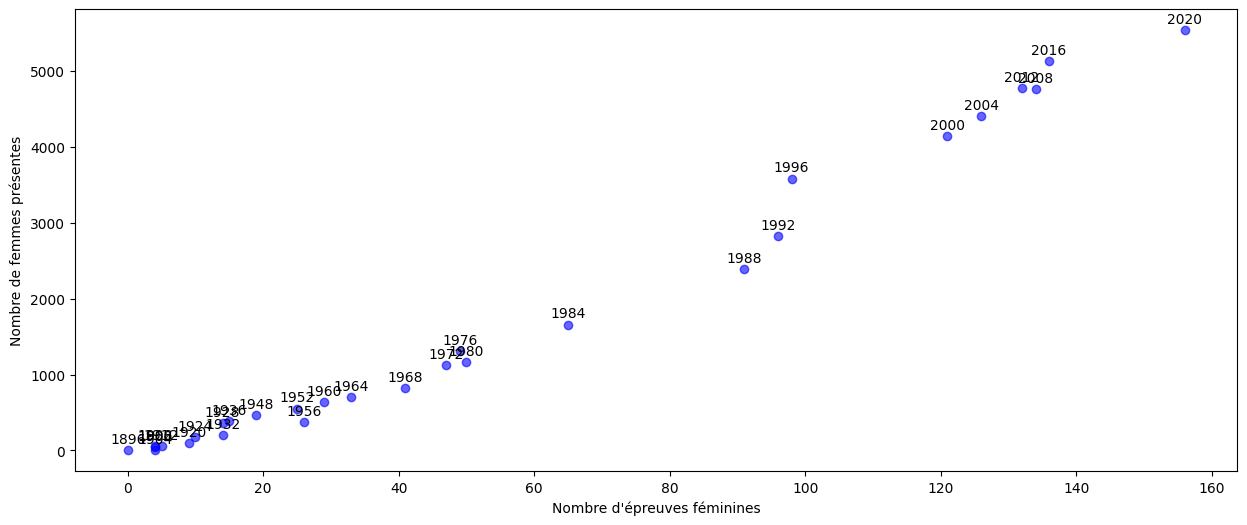

In [116]:
# taille de la figure
plt.figure(figsize=(15, 6))
# initalisation d'un nuage de point avec x: NBEPREUVEFEMME et y : NBFEMME
plt.scatter(df_femme['NBEPREUVEFEMME'], df_femme['NBFEMME'], color='blue', alpha=0.6)
# Ajouter des labels et un titre
display(HTML(f"<b><font size='+2'>Évolution du nombre d'épreuves féminines par rapport au nombre de femmes présentes</font></b>"))
plt.xlabel("Nombre d'épreuves féminines")
plt.ylabel("Nombre de femmes présentes")
# affichage des années des JO au déssus des points
for i in range(len(df_femme)):
    plt.annotate(df_femme['ANNEEHOTE'][i], (df_femme['NBEPREUVEFEMME'][i], df_femme['NBFEMME'][i]), textcoords="offset points", xytext=(0,5), ha='center')


# Afficher le nuage de points
plt.show()

Interpréter et/ou expliquer ce qui est présenté : On vois que depuis l'édition de 1980, la corrélation nombre de femme présente, nombre d'événement Femme augmentent exponentiellement, ce qui montre qu'il y a de plus en plus de considération pour les femmes lors des Jeux Olympique. Ce graphique montre également que lors des prémières éditions, il y avait très peu d'épreuve pour les femmes, et donc très peu de femme participantes.

# Performance de l'équipe de votre choix